In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-stock-dataset/AMZN.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Set seaborn style for better visuals
sns.set_style("darkgrid")

In [3]:
url = "https://huggingface.co/datasets/asyraffucl/amazon-stock-data/resolve/main/AMZN.csv"
df = pd.read_csv(url, parse_dates=["Date"], index_col="Date")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


# **Step 3: Ploting the Adjusted Closing Prices**

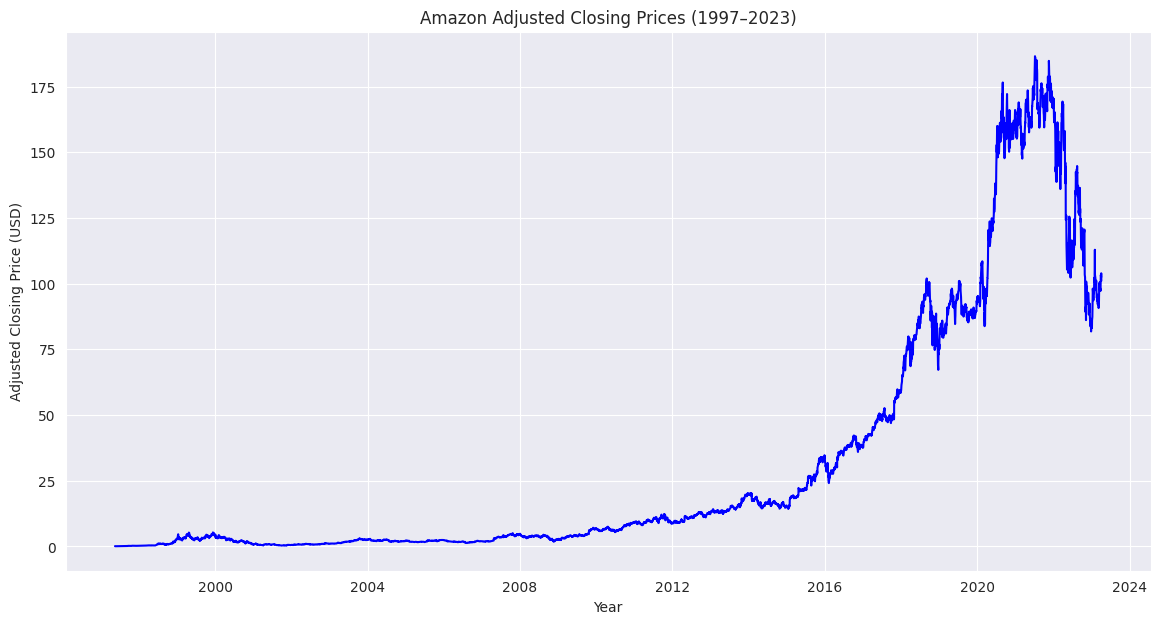

In [4]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Adj Close'], color='blue')
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Price (USD)')
plt.title('Amazon Adjusted Closing Prices (1997–2023)')
plt.show()

**Observations:**

> The plot shows an upward trend, indicating non-stationarity.

> There might be seasonal patterns or structural breaks in the data.

# **Step 4: Performing the Augmented Dickey-Fuller (ADF) Test**

In [5]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    if result[1] < 0.05:
        print("The time series is stationary (reject H0).")
    else:
        print("The time series is non-stationary (fail to reject H0).")

# Apply ADF test on the adjusted closing prices
adf_test(df['Adj Close'])

ADF Statistic: -0.44578758230603305
p-value: 0.9021686463445395
Critical Value (1%): -3.431359395451861
Critical Value (5%): -2.8619860660773804
Critical Value (10%): -2.5670074376517156
The time series is non-stationary (fail to reject H0).


**Interpretation:**
* Null Hypothesis (H0): The series is non-stationary.
* Alternative Hypothesis (H1): The series is stationary.
* If the p-value is less than 0.05, we reject H0, indicating stationarity.

# **Step 5: Applying First-Order Differencing**

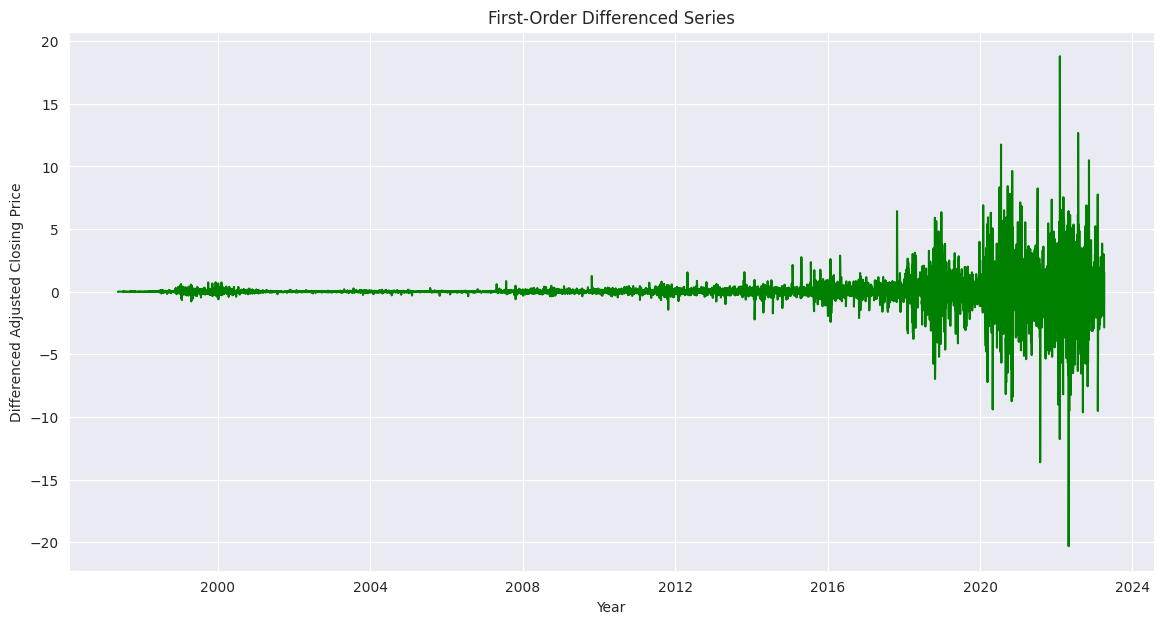

ADF Statistic: -13.690631605249312
p-value: 1.3460788089749518e-25
Critical Value (1%): -3.4313597071653335
Critical Value (5%): -2.861986203804562
Critical Value (10%): -2.5670075109669024
The time series is stationary (reject H0).


In [6]:
df['Adj Close Diff'] = df['Adj Close'].diff()

# Plot the differenced series
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Adj Close Diff'], color='green')
plt.xlabel('Year')
plt.ylabel('Differenced Adjusted Closing Price')
plt.title('First-Order Differenced Series')
plt.show()

# ADF test on the differenced series
adf_test(df['Adj Close Diff'])

**Observations:**
> Differencing the series helps in removing the trend.

> The ADF test on the differenced series will help determine if it has become stationary.

# **Step 6: Applying Log Transformation**

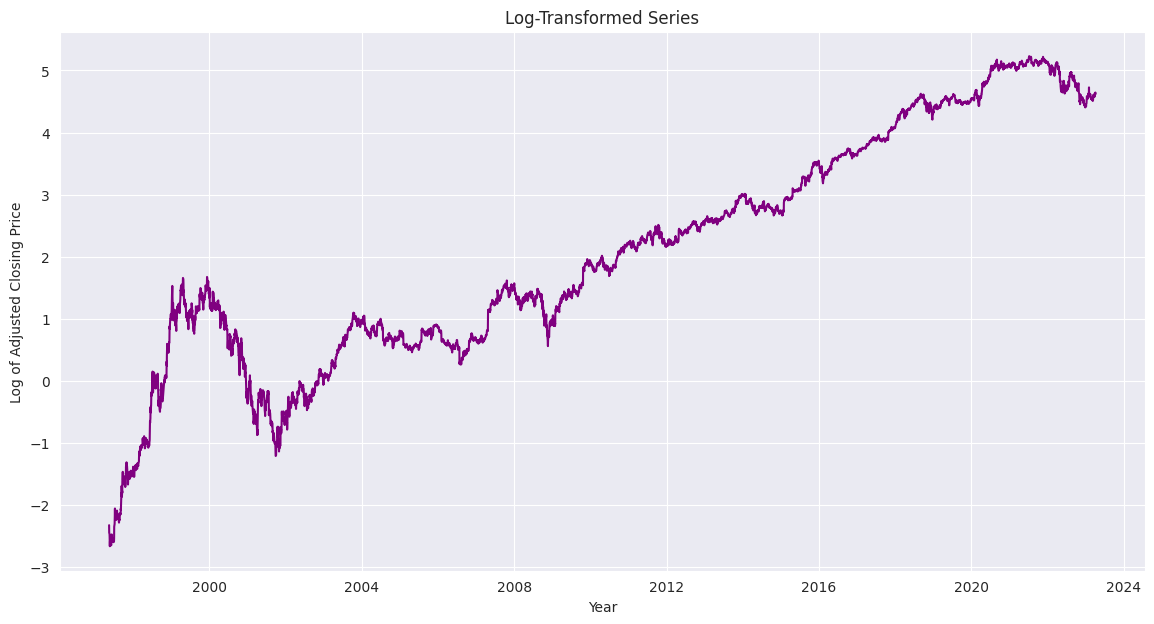

ADF Statistic: -2.081605767699709
p-value: 0.251975046887685
Critical Value (1%): -3.431359395451861
Critical Value (5%): -2.8619860660773804
Critical Value (10%): -2.5670074376517156
The time series is non-stationary (fail to reject H0).


In [7]:
df['Log Adj Close'] = np.log(df['Adj Close'])

# Plot the log-transformed series
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Log Adj Close'], color='purple')
plt.xlabel('Year')
plt.ylabel('Log of Adjusted Closing Price')
plt.title('Log-Transformed Series')
plt.show()

# ADF test on the log-transformed series
adf_test(df['Log Adj Close'])

**Observations:**
> Log transformation can help stabilize the variance in the series.

> It's often used before differencing to address heteroscedasticity.

# **Step 7: Applying Seasonal Differencing**

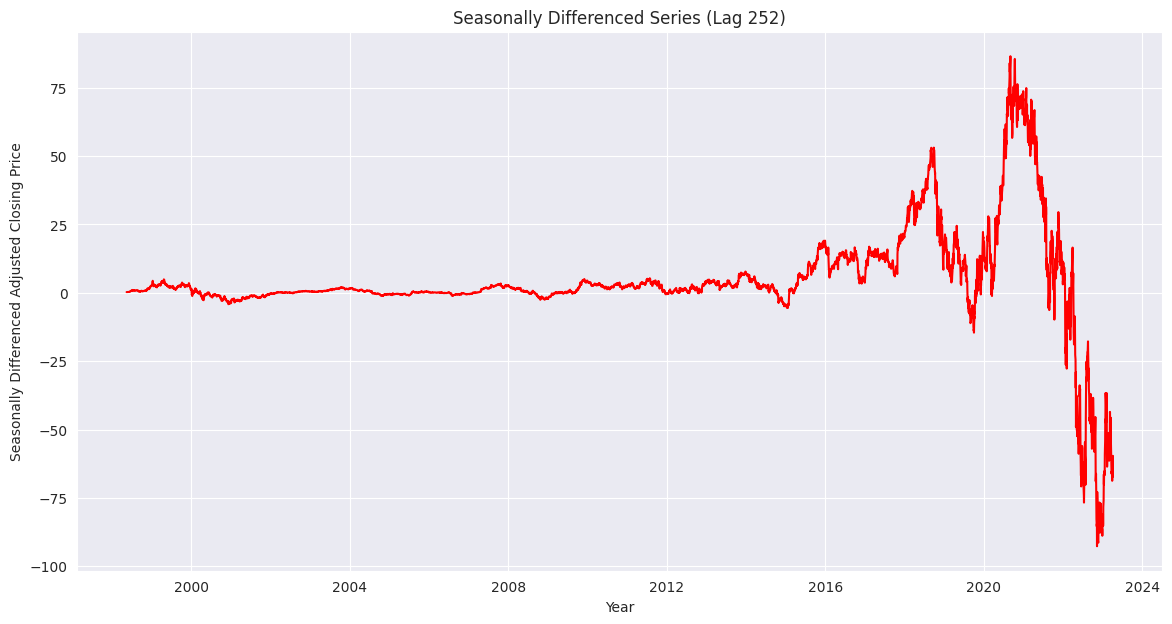

ADF Statistic: -1.6858972401014785
p-value: 0.43839289853872904
Critical Value (1%): -3.4314002483322836
Critical Value (5%): -2.8620041163518737
Critical Value (10%): -2.5670170462281603
The time series is non-stationary (fail to reject H0).


In [8]:
df['Seasonal Diff'] = df['Adj Close'] - df['Adj Close'].shift(252)  # Approximate number of trading days in a year

# Plot the seasonally differenced series
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Seasonal Diff'], color='red')
plt.xlabel('Year')
plt.ylabel('Seasonally Differenced Adjusted Closing Price')
plt.title('Seasonally Differenced Series (Lag 252)')
plt.show()

# ADF test on the seasonally differenced series
adf_test(df['Seasonal Diff'])

**Observations:**
> Seasonal differencing helps in removing seasonal patterns.

> A lag of 252 is used, corresponding to the number of trading days in a year.

# **Step 8: Building an ARIMA Model for Forecasting**

**Since i have made our series stationary, i can now apply an ARIMA (AutoRegressive Integrated Moving Average) model for time series forecasting.**

In [9]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output

# **Step 8.2: Defining the ARIMA Model**

**The ARIMA model has three parameters:**

* p (AutoRegression - AR): Number of lag observations included.
  
* d (Integrated - I): Number of times differencing is applied.

  
* q (Moving Average - MA): Size of the moving average window.

  
*will use first-order differencing (d=1) because i already observed that it makes our time series stationary*

In [10]:
# Defining the ARIMA model (p=5, d=1, q=0)
model = ARIMA(df['Adj Close'], order=(5,1,0))  # Using p=5 based on historical patterns
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 6516
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10676.350
Date:                Mon, 03 Mar 2025   AIC                          21364.699
Time:                        09:36:32   BIC                          21405.391
Sample:                             0   HQIC                         21378.772
                               - 6516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0184      0.004     -4.124      0.000      -0.027      -0.010
ar.L2          0.0230      0.005      4.526      0.000       0.013       0.033
ar.L3         -0.0433      0.004     -9.687      0.0

**🔹 Why ARIMA(5,1,0)?**

* I used p=5 because stock prices often have short-term memory.
  
* d=1 ensures stationarity.

  
* q=0 means we are not using the moving average component.

# **Step 8.3: Forecast Future Values**

In [11]:
forecast = model_fit.forecast(steps=30)
future_dates = pd.date_range(start=df.index[-1], periods=30, freq='B')  # 'B' means business days
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': forecast})
forecast_df.set_index('Date', inplace=True)

print(forecast_df.head())

            Predicted Price
Date                       
2023-04-05       101.231022
2023-04-06       101.053997
2023-04-07       101.236221
2023-04-10       101.127497
2023-04-11       101.189182


# **Step 8.4: Plot the Forecasted Stock Prices**

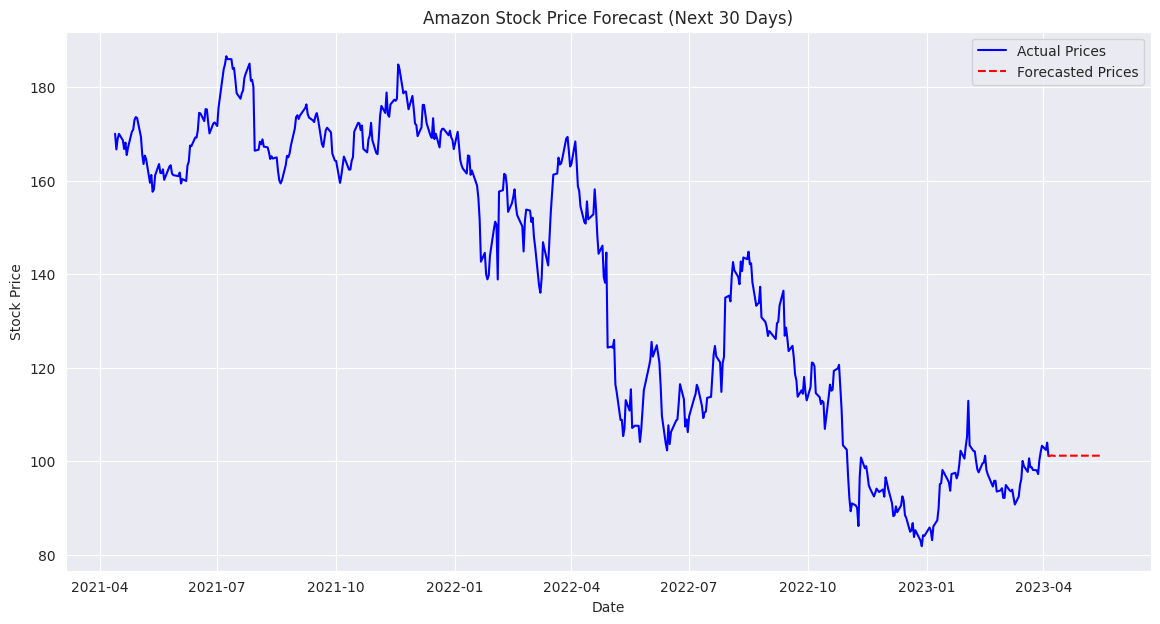

In [12]:
plt.figure(figsize=(14, 7))

# Plot the historical prices
plt.plot(df.index[-500:], df['Adj Close'][-500:], label="Actual Prices", color="blue")

plt.plot(forecast_df.index, forecast_df['Predicted Price'], label="Forecasted Prices", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Amazon Stock Price Forecast (Next 30 Days)")
plt.legend()
plt.show()

# **Step 9: Evaluate the ARIMA Model using Mean Absolute Error (MAE) and Root Mean Square Error (RMSE).**

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

df['Predicted'] = model_fit.fittedvalues
mae = mean_absolute_error(df['Adj Close'].dropna(), df['Predicted'].dropna())
rmse = np.sqrt(mean_squared_error(df['Adj Close'].dropna(), df['Predicted'].dropna()))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 0.49
Root Mean Square Error (RMSE): 1.25


**Interpretation:**
> Lower MAE and RMSE values indicate a better model fit.

> If errors are high, consider tuning ARIMA hyperparameters (p, d, q).

# **Step 10: Model Improvement – Hyperparameter Tuning**

*Instead of manually choosing (p, d, q), we can use Auto ARIMA, which selects the best parameters automatically.*

In [14]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.6 MB/s eta 0:00:00


In [15]:
from pmdarima import auto_arima

# Use auto_arima to find the best ARIMA order
best_arima = auto_arima(df['Adj Close'], seasonal=False, stepwise=True, trace=True)

print(best_arima.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21310.991, Time=8.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21381.378, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21380.312, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21380.454, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21380.383, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21369.497, Time=2.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21369.934, Time=2.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=21311.619, Time=11.76 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=21311.641, Time=10.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21371.692, Time=2.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=21363.900, Time=2.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=21365.312, Time=2.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=21311.714, Time=11.01 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=21309.995, Time=3.80 sec
 ARIMA(1,1,2)(0,

> **🔹 This will find the best (p, d, q) values automatically based on AIC (Akaike Information Criterion).**

# **📖 Stock Price Forecasting Using LSTM**

***🌟 Introduction
Imagine you are a data scientist at a top financial firm, and your task is to predict stock prices using deep learning techniques. The management wants to know whether an AI-driven approach can help in forecasting market movements.***


***Your solution? LSTM (Long Short-Term Memory) networks, a powerful type of neural network specifically designed to handle time-series data.***


***But first, let’s prepare our data and build a model step by step. 📊💡***

**LSTMs are a type of Recurrent Neural Network (RNN) that are well-suited for time-series forecasting because they can capture long-term dependencies in the data.**

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# **Step 11.2: Data Preprocessing for LSTM**

> I'll use MinMaxScaler to transform the stock prices into a scale between 0 and 1, helping the model learn patterns effectively.

**Why do we scale?
LSTMs perform better with scaled data.
It helps prevent large values from dominating small values.**

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

> **LSTMs don’t just look at one data point they need sequences to learn patterns over time.**


> **Imagine you’re studying for an exam. Instead of memorizing one fact, you study a series of related topics to understand the subject better. That’s exactly what LSTM does**


> **I'll create a function that splits the stock prices into sequences of 50 days.**

# **Step 11.3: Build the LSTM Model**

**🚀 Now comes the exciting part – designing the deep learning model!**

**I'll use an LSTM-based architecture to make the stock price predictions. Our network consists of:**

> Two LSTM layers – These capture time-based patterns.

> Dropout layers – To prevent overfitting.

> Dense layers – To produce the final prediction.

In [18]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

**📌 Why use Dropout?
It helps prevent the model from becoming too dependent on training data and improves generalization.**

# **Step 11.4: Train the LSTM Model**

In [19]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 8.1676e-04 - val_loss: 0.0016
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 8.8940e-05 - val_loss: 0.0027
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 8.1511e-05 - val_loss: 0.0063
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 6.6655e-05 - val_loss: 0.0010
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 5.5626e-05 - val_loss: 0.0073
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 6.0550e-05 - val_loss: 0.0012
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 5.2749e-05 - val_loss: 0.0044
Epoch 8/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 5.7611e-05 - val_loss: 9.7680e-04
Epoch 9/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 4.8694e-05 - val_loss: 0.0014
Epoch 10/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 4.8331e-05 - val_loss: 9.2258e-04
Epoch 11/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 4.7313e-05 - val_l

**📌 Epochs?
Each epoch is one complete pass through the dataset. More epochs generally mean better learning—but too many can cause overfitting.**

# **Step 11.5: Make Predictions**

In [20]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

actual_prices = scaler.inverse_transform(y_test.reshape(-1,1))

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


**📌 Why inverse transform?
i originally scaled the data, so i need to convert it back to real stock prices.**

# **Step 11.6: Plot Predictions vs. Actual Prices**

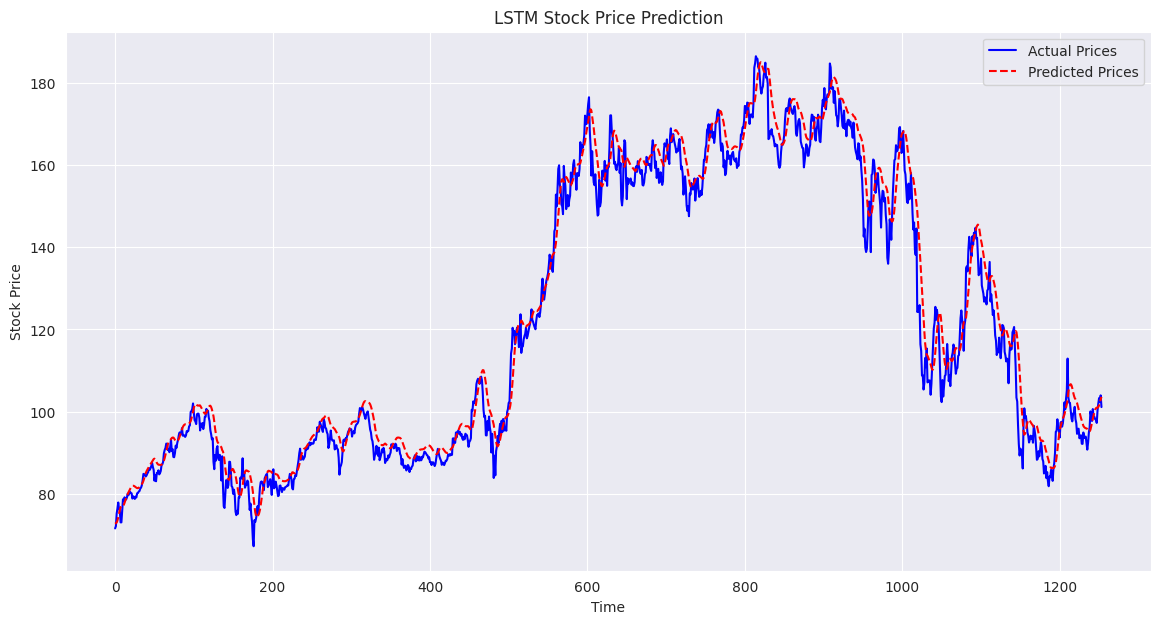

In [21]:
plt.figure(figsize=(14,7))
plt.plot(actual_prices, label="Actual Prices", color="blue")
plt.plot(predicted_prices, label="Predicted Prices", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("LSTM Stock Price Prediction")
plt.legend()
plt.show()

**📌 Observations
The red dashed line (predictions) closely follows the blue line (actual prices), our model is performing well.**
**If there’s a big gap, i may need to tune our model further.**

# ***📖 Fine-Tuning the LSTM Model – Step 12***

***🚀 After building our LSTM model, it's time to fine-tune it for better accuracy!***


***Even though the predictions look promising, i can always improve performance. Let’s tune the hyperparameters and optimize the model further.***

**🔍 What is Fine-Tuning?**

**Fine-tuning means adjusting the model’s parameters to enhance performance. In deep learning, this involves:**

>  Increasing or decreasing epochs (more training cycles)

>  Changing the batch size (number of samples per training step)

>  Modifying the number of LSTM units (memory capacity)

>  Adjusting the dropout rate (prevent overfitting)

>  Trying different optimizers (Adam, RMSprop, SGD)

**📌 Step 12: Fine-Tuning the Model**

**🎯 The Goal: Improve accuracy while preventing overfitting.
After analyzing the first model, will found:**

* Predictions were good but could be smoother.
  
* The model slightly overfit to training data.

  
* Training time was high due to complex layers.

  
**Solution?
I'll increase dropout, adjust LSTM units, and use early stopping to find the best epoch count.**

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(units=60, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.3),  # Increased dropout to reduce overfitting
    LSTM(units=60, return_sequences=True),
    Dropout(0.3),
    LSTM(units=60),
    Dropout(0.3),
    Dense(units=30, activation='relu'),  # Extra dense layer for better feature learning
    Dense(units=1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=50, batch_size=16, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop])

Epoch 1/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - loss: 7.1399e-04 - val_loss: 0.0053
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 1.2243e-04 - val_loss: 0.0024
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 1.0340e-04 - val_loss: 0.0077
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 9.0869e-05 - val_loss: 0.0034
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 8.7053e-05 - val_loss: 0.0030
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 8.6402e-05 - val_loss: 0.0015
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 6.6988e-05 - val_loss: 0.0019
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 9.3580e-05 - val_loss: 0.0013
Epoch 9/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 1.0617e-04 - val_loss: 0.0018
Epoch 10/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 7.6992e-05 - val_loss: 0.0019
Epoch 11/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 6.7679e-05 - val

# **📌 Step 13: Evaluating the Fine-Tuned Model**

In [23]:
predicted_prices_tuned = model.predict(X_test)
predicted_prices_tuned = scaler.inverse_transform(predicted_prices_tuned)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


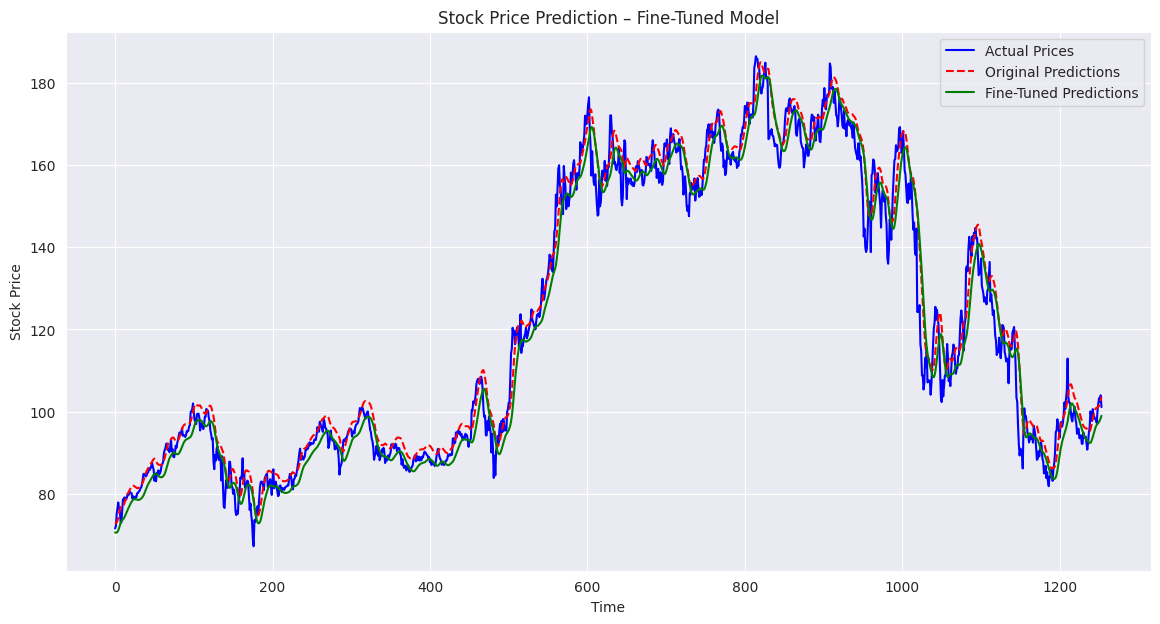

In [24]:
plt.figure(figsize=(14,7))
plt.plot(actual_prices, label="Actual Prices", color="blue")
plt.plot(predicted_prices, label="Original Predictions", color="red", linestyle="dashed")
plt.plot(predicted_prices_tuned, label="Fine-Tuned Predictions", color="green")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction – Fine-Tuned Model")
plt.legend()
plt.show()

**✅ Improvement Check
The green line (fine-tuned predictions) is closer to blue (actual prices), we succeeded!**

**The error should decrease after fine-tuning.**